Import necessary modules.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv

Load dataset into data variable.

In [2]:
data = pd.read_csv('airbus-ship-detection/train/train_ship_segmentations.csv')

Display the first 5 rows of the loaded dataset.

In [13]:
data.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


Now we check the shape of the dataset.

In [7]:
print('Dataset shape:', data.shape)

Dataset shape: (231723, 2)


Check and print the data types of each column.

In [9]:
print('Data types:')
data.dtypes

Data types:


ImageId          object
EncodedPixels    object
dtype: object

Check for missing values in dataset.

In [10]:
print('Missing values:')
data.isnull().sum()

Missing values:


ImageId               0
EncodedPixels    150000
dtype: int64

Count the number of images with and without ships.

In [26]:

ship_counts = data['EncodedPixels'].notnull().value_counts()
print('Number of images with and without ships:')
ship_counts

Number of images with and without ships:


EncodedPixels
False    150000
True      81723
Name: count, dtype: int64

Print first 10 image sizes.

In [22]:
data_path = 'airbus-ship-detection/train/'
image_id = data['ImageId'].values
count = 0
for image_name in image_id:
    if count == 10:
        break
    count += 1
    img = cv.imread(data_path + image_name+'.jpg')
    print(f'image number {count} has size = {img.shape}')




image number 1 has size = (768, 768, 3)
image number 2 has size = (768, 768, 3)
image number 3 has size = (768, 768, 3)
image number 4 has size = (768, 768, 3)
image number 5 has size = (768, 768, 3)
image number 6 has size = (768, 768, 3)
image number 7 has size = (768, 768, 3)
image number 8 has size = (768, 768, 3)
image number 9 has size = (768, 768, 3)
image number 10 has size = (768, 768, 3)


Visualize example images with ships.

Text(0.5, 1.0, 'Fourth')

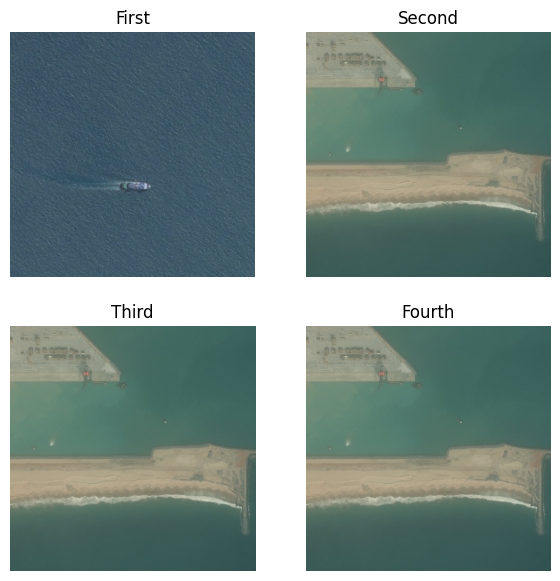

In [35]:
ship_images =  data.loc[data['EncodedPixels'].notnull()]
data_path = 'airbus-ship-detection/train/'

# create figure
fig = plt.figure(figsize=(7, 7))
  
# setting values to rows and column variables
rows = 2
columns = 2

# reading images
Image1 = cv.cvtColor(cv.imread(data_path + ship_images['ImageId'].iloc[0]+'.jpg'),cv.COLOR_BGR2RGB)
Image2 = cv.cvtColor(cv.imread(data_path + ship_images['ImageId'].iloc[1]+'.jpg'),cv.COLOR_BGR2RGB)
Image3 = cv.cvtColor(cv.imread(data_path + ship_images['ImageId'].iloc[2]+'.jpg'),cv.COLOR_BGR2RGB)
Image4 = cv.cvtColor(cv.imread(data_path + ship_images['ImageId'].iloc[3]+'.jpg'),cv.COLOR_BGR2RGB)
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("First")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Second")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Third")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("Fourth")

Visualize example images without ships

Text(0.5, 1.0, 'Fourth')

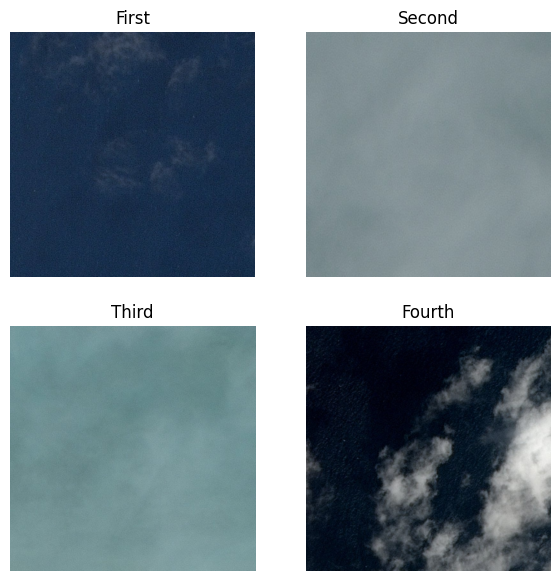

In [36]:
ship_images =  data.loc[~data['EncodedPixels'].notnull()]
data_path = 'airbus-ship-detection/train/'

# create figure
fig = plt.figure(figsize=(7, 7))
  
# setting values to rows and column variables
rows = 2
columns = 2

# reading images
Image1 = cv.cvtColor(cv.imread(data_path + ship_images['ImageId'].iloc[0]+'.jpg'),cv.COLOR_BGR2RGB)
Image2 = cv.cvtColor(cv.imread(data_path + ship_images['ImageId'].iloc[1]+'.jpg'),cv.COLOR_BGR2RGB)
Image3 = cv.cvtColor(cv.imread(data_path + ship_images['ImageId'].iloc[2]+'.jpg'),cv.COLOR_BGR2RGB)
Image4 = cv.cvtColor(cv.imread(data_path + ship_images['ImageId'].iloc[3]+'.jpg'),cv.COLOR_BGR2RGB)
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("First")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Second")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Third")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("Fourth")